In [47]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [48]:
%cd /content/drive/My\ Drive/PGDBA\ Academics/IIM/EMABE

/content/drive/My Drive/PGDBA Academics/IIM/EMABE


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
df = pd.read_csv('final.csv')

In [51]:
df['buildingPropertyValue'].describe()

,buildingPropertyValue
count,2.436920e+05
mean,6.105557e+05
std,2.200865e+07
min,0.000000e+00
25%,6.961500e+04
50%,1.065455e+05
75%,1.668610e+05
max,1.920000e+09


In [52]:
df = df[df['amountPaidOnBuildingClaim']<1500000]
df = df[df['buildingDamageAmount']<2000000]
df = df[df['BuildingAge']<150]
df = df[df['amountPaidOnIncreasedCostOfComplianceClaim']<32000]
df = df[df['buildingPropertyValue']!=0]

In [53]:
# prompt: Pass this statsmodel for linear regression and show the column that has significance

import statsmodels.api as sm


cols_of_Reg = [
 'policyCount',
 'elevatedBuildingIndicator',
 'nonProfitIndicator',
 'postFIRMConstructionIndicator',
 'smallBusinessIndicatorBuilding',
 'totalBuildingInsuranceCoverage',
 'totalContentsInsuranceCoverage',
 'yearOfLoss',
 'primaryResidenceIndicator',
 'buildingDamageAmount',
 'buildingPropertyValue',
 'floodWaterDuration',
 'iccCoverage',
 'nfipRatedCommunityNumber',
 'numberOfUnits',
 'buildingReplacementCost',
 'waterDepth',
 'rentalPropertyIndicator',
 #'amountPaidOnContentsClaim',
 #'amountPaidOnIncreasedCostOfComplianceClaim',
 'BuildingAge',
 'amountPaidOnBuildingClaim']


df = df[cols_of_Reg]


# Define the dependent variable (y) and independent variables (X)
# Assuming 'amountPaidOnBuildingClaim' is the target variable you want to predict
y = df['amountPaidOnBuildingClaim']
X = df.drop('amountPaidOnBuildingClaim', axis=1)

# Add a constant to the independent variables matrix (for the intercept)
X = sm.add_constant(X)

# Fit the linear regression model using OLS (Ordinary Least Squares)
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())



                                OLS Regression Results                               
Dep. Variable:     amountPaidOnBuildingClaim   R-squared:                       0.870
Model:                                   OLS   Adj. R-squared:                  0.870
Method:                        Least Squares   F-statistic:                 8.576e+04
Date:                       Thu, 19 Jun 2025   Prob (F-statistic):               0.00
Time:                               18:33:54   Log-Likelihood:            -2.7343e+06
No. Observations:                     243498   AIC:                         5.469e+06
Df Residuals:                         243478   BIC:                         5.469e+06
Df Model:                                 19                                         
Covariance Type:                   nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Transformation**

In [54]:
# prompt: perform Partial F test on column 'smallBusinessIndicatorBuilding'

# Full Model
X_full = df.drop('amountPaidOnBuildingClaim', axis=1)
X_full = sm.add_constant(X_full)
model_full = sm.OLS(y, X_full).fit()

# Reduced Model (excluding 'smallBusinessIndicatorBuilding')
X_reduced = df.drop(['amountPaidOnBuildingClaim', 'smallBusinessIndicatorBuilding'], axis=1)
X_reduced = sm.add_constant(X_reduced)
model_reduced = sm.OLS(y, X_reduced).fit()

# Perform the Partial F-test
# F-statistic = ((SSE_reduced - SSE_full) / (df_full - df_reduced)) / (SSE_full / df_full)
# where SSE is the Sum of Squared Errors and df is the degrees of freedom

sse_full = model_full.ssr
sse_reduced = model_reduced.ssr
df_full = model_full.df_resid
df_reduced = model_reduced.df_resid

f_statistic = ((sse_reduced - sse_full) / (df_reduced - df_full)) / (sse_full / df_full)

# Calculate p-value for the F-statistic
from scipy.stats import f
p_value = f.sf(f_statistic, (df_reduced - df_full), df_full)

print(f"Partial F-test for 'smallBusinessIndicatorBuilding':")
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpret the result (common significance level is 0.05)
if p_value < 0.05:
  print("The variable 'smallBusinessIndicatorBuilding' is statistically significant in the model.")
else:
  print("The variable 'smallBusinessIndicatorBuilding' is not statistically significant in the model.")

Partial F-test for 'smallBusinessIndicatorBuilding':
F-statistic: 0.15824986032609012
P-value: 0.6907733143963054
The variable 'smallBusinessIndicatorBuilding' is not statistically significant in the model.


In [55]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset

# (Assuming you’ve already dropped 'Unnamed: 0' and defined X, y, and fitted `model`)

# Perform Ramsey RESET test
#   power=2 adds fittedvalues**2 as extra regressors
#   use_f=True returns the F-test (instead of a chi-square)
reset_res = linear_reset(model, power=2, use_f=True)

# reset_res is a ResetResult instance with attributes:
#   .fvalue, .pvalue, .df_denom, .df_num
print(f"RESET test F-statistic: {reset_res.fvalue:.4f}")
print(f"RESET test p-value:      {reset_res.pvalue:.4f}")
print(f"Degrees of freedom:      ({reset_res.df_num}, {reset_res.df_denom})")

RESET test F-statistic: 78539.2677
RESET test p-value:      0.0000
Degrees of freedom:      (1.0, 243477.0)


In [56]:
#Transformations

df['logPolicyCount'] = np.log(df['policyCount']+1)
df['logtotalBuildingInsuranceCoverage'] = np.log(df['totalBuildingInsuranceCoverage']+1)
df['logBuildingPropertyValue'] = np.log(df['buildingPropertyValue']+1)
df['logBuildingReplacementCost'] = np.log(df['buildingReplacementCost']+1)
df['signedLogWwaterDepth'] = np.sign(df['waterDepth']) * \
    np.log1p(np.abs(df['waterDepth']))
df['logamountPaidOnBuildingClaim'] = np.log1p(abs(df['amountPaidOnBuildingClaim']))
df['logTotalContentsInsuranceCoverage'] = np.log1p(df['totalContentsInsuranceCoverage'])



'''cols_of_Reg = [

 'logPolicyCount',
 'postFIRMConstructionIndicator',
 #'smallBusinessIndicatorBuilding',
 'logtotalBuildingInsuranceCoverage',
 'logTotalContentsInsuranceCoverage',
 'yearOfLoss',
 'primaryResidenceIndicator',
 'buildingDamageAmount',
 'logBuildingPropertyValue',
 'iccCoverage',
 'logBuildingReplacementCost',
 'signedLogWwaterDepth',
 'rentalPropertyIndicator',
# 'BuildingAge',
 'amountPaidOnBuildingClaim',
 ]'''

cols_of_Reg = [

 'policyCount',
 'postFIRMConstructionIndicator',
 #'smallBusinessIndicatorBuilding',
 'totalBuildingInsuranceCoverage',
 'totalContentsInsuranceCoverage',
 'yearOfLoss',
 'primaryResidenceIndicator',
 'buildingDamageAmount',
 'buildingPropertyValue',
 'iccCoverage',
 'buildingReplacementCost',
 'signedLogWwaterDepth',
 'rentalPropertyIndicator',
# 'BuildingAge',
 'amountPaidOnBuildingClaim',
 ]




df_reg = df[cols_of_Reg]


# Define the dependent variable (y) and independent variables (X)
# Assuming 'amountPaidOnBuildingClaim' is the target variable you want to predict
y = df_reg['amountPaidOnBuildingClaim']
X = df_reg.drop('amountPaidOnBuildingClaim', axis=1)

# Add a constant to the independent variables matrix (for the intercept)
X = sm.add_constant(X)

# Fit the linear regression model using OLS (Ordinary Least Squares)
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())



                                OLS Regression Results                               
Dep. Variable:     amountPaidOnBuildingClaim   R-squared:                       0.870
Model:                                   OLS   Adj. R-squared:                  0.870
Method:                        Least Squares   F-statistic:                 1.359e+05
Date:                       Thu, 19 Jun 2025   Prob (F-statistic):               0.00
Time:                               18:33:55   Log-Likelihood:            -2.7342e+06
No. Observations:                     243498   AIC:                         5.469e+06
Df Residuals:                         243485   BIC:                         5.469e+06
Df Model:                                 12                                         
Covariance Type:                   nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [57]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset

# (Assuming you’ve already dropped 'Unnamed: 0' and defined X, y, and fitted `model`)

# Perform Ramsey RESET test
#   power=2 adds fittedvalues**2 as extra regressors
#   use_f=True returns the F-test (instead of a chi-square)
reset_res = linear_reset(model, power=2, use_f=True)

# reset_res is a ResetResult instance with attributes:
#   .fvalue, .pvalue, .df_denom, .df_num
print(f"RESET test F-statistic: {reset_res.fvalue:.4f}")
print(f"RESET test p-value:      {reset_res.pvalue:.4f}")
print(f"Degrees of freedom:      ({reset_res.df_num}, {reset_res.df_denom})")

RESET test F-statistic: 77938.9899
RESET test p-value:      0.0000
Degrees of freedom:      (1.0, 243484.0)


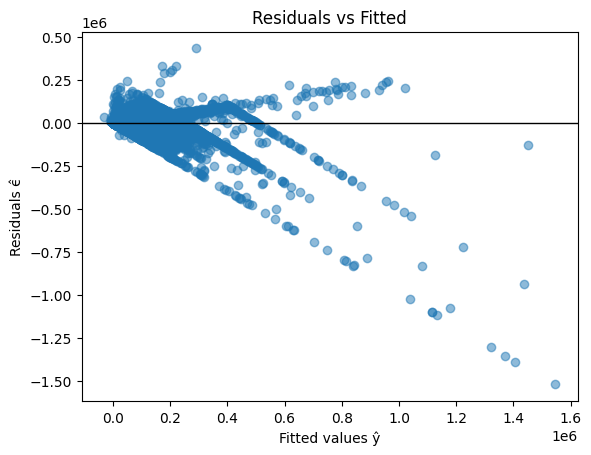

In [58]:
import matplotlib.pyplot as plt

plt.scatter(model.fittedvalues, model.resid, alpha=0.5)
plt.axhline(0, color='k', lw=1)
plt.xlabel('Fitted values ŷ'); plt.ylabel('Residuals ϵ̂')
plt.title('Residuals vs Fitted')
plt.show()

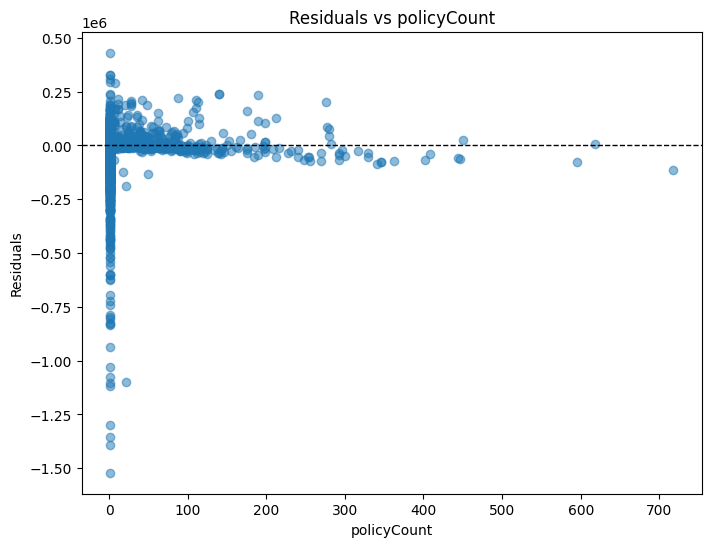

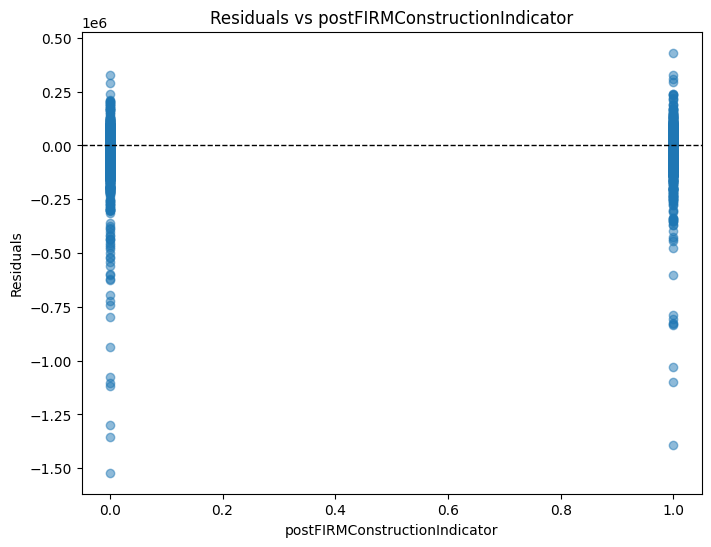

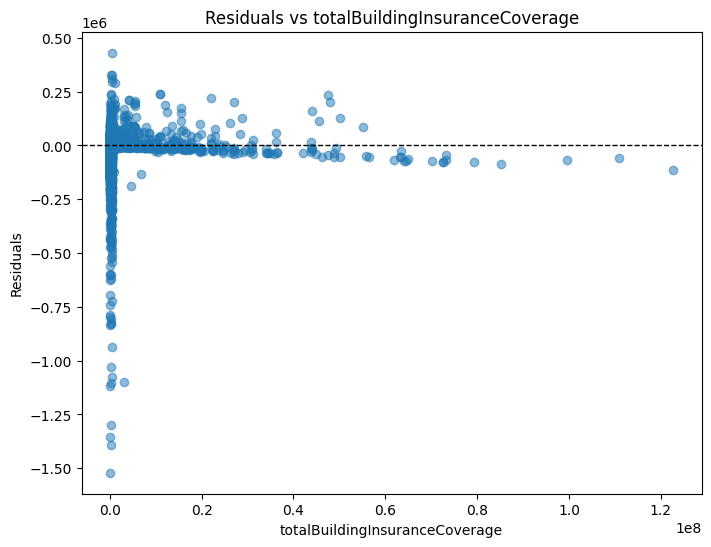

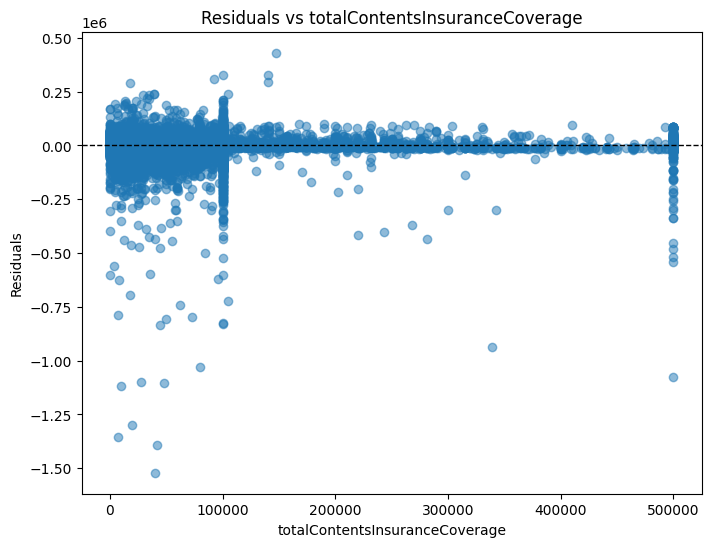

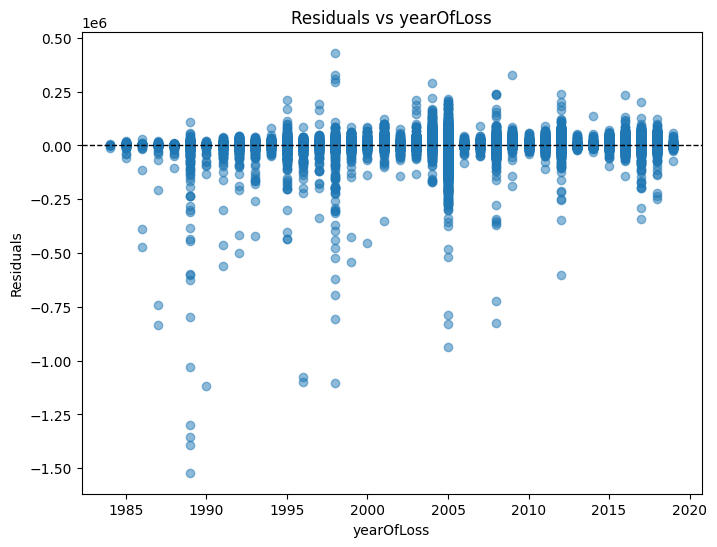

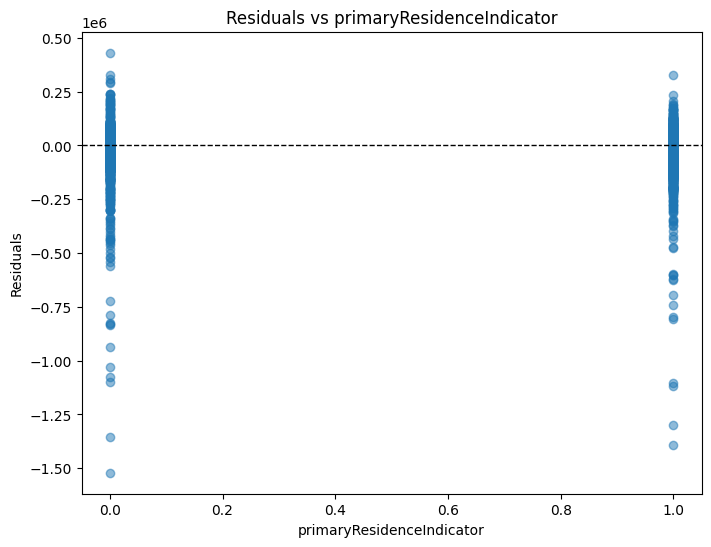

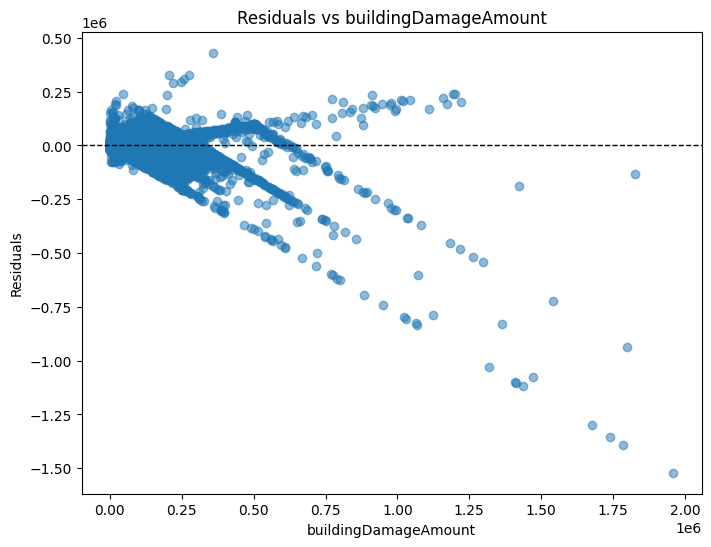

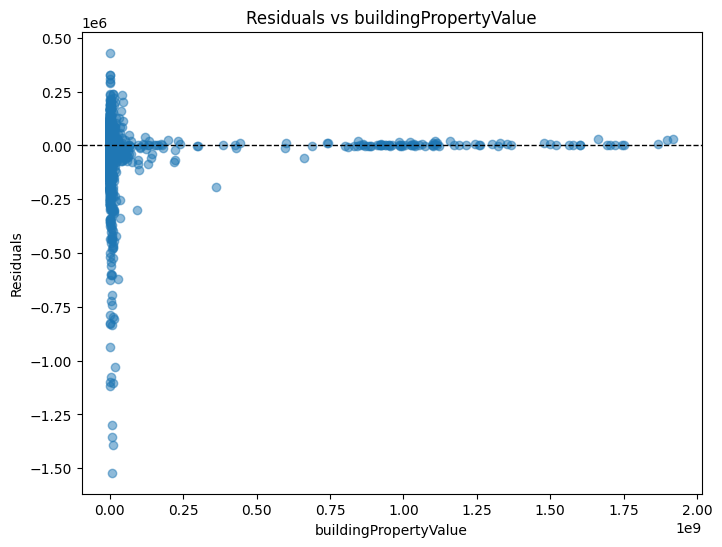

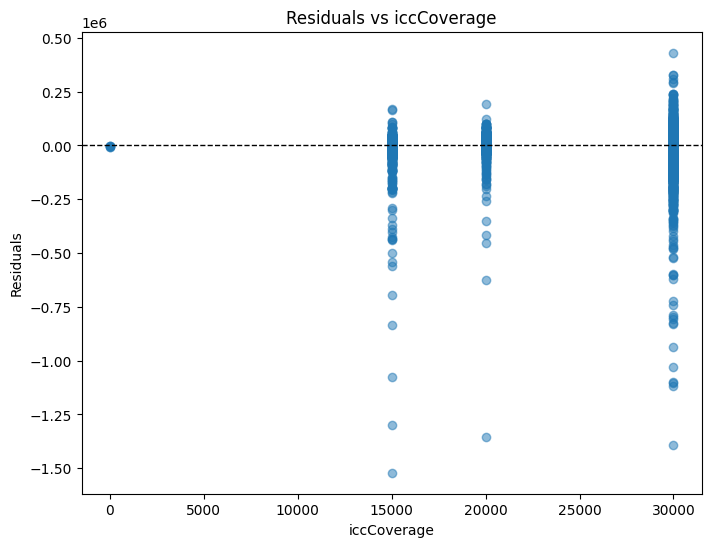

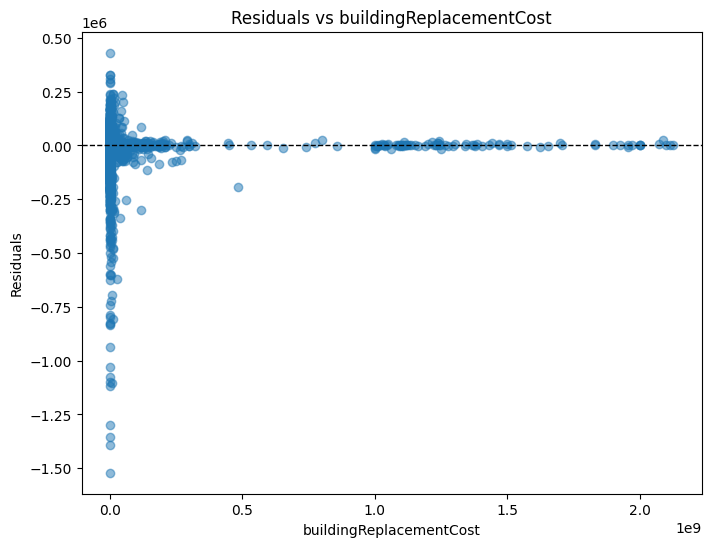

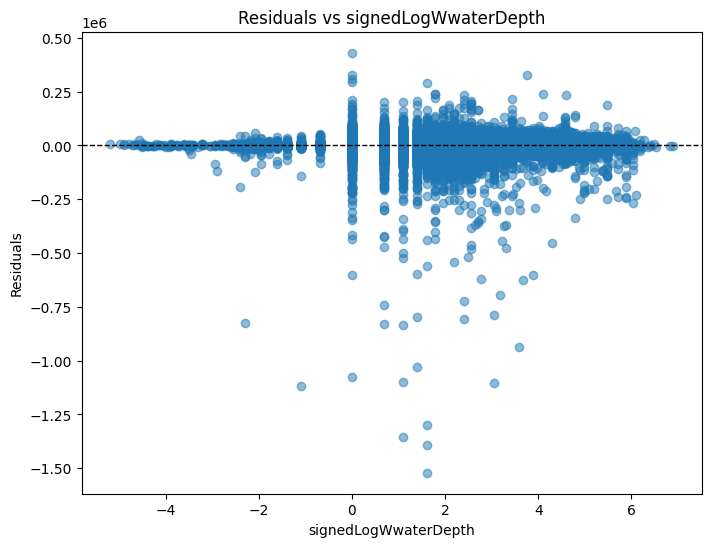

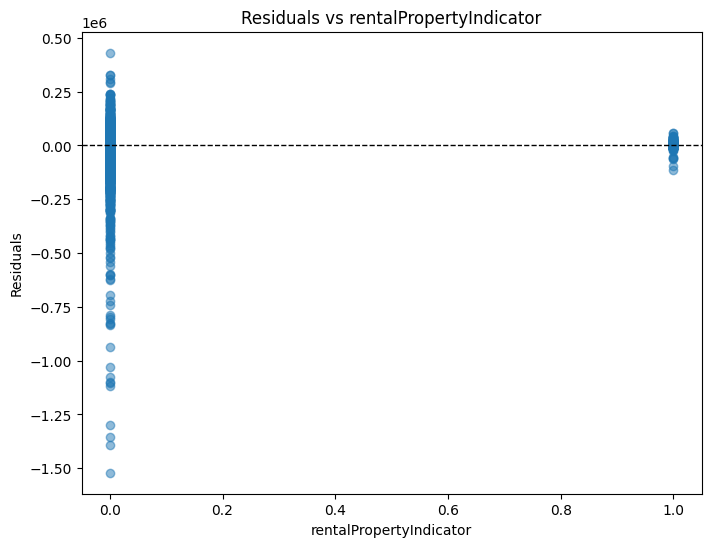

In [59]:
# prompt: General residuals plot for all X variables

# Get residuals and predicted values
residuals = model.resid
predicted_values = model.fittedvalues

# Get the independent variables (excluding the constant)
X_vars = X.drop('const', axis=1)

# Plot residuals against each independent variable
for col in X_vars.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_vars[col], residuals, alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', lw=1)
    plt.xlabel(col)
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs {col}')
    plt.show()

In [60]:
# prompt: Create a model of second order based on the columns from cols_of_Reg and share the summary of it.

# Create a second-order model
X_second_order = X.copy()
for col in X.columns:
    if col != 'const':
        X_second_order[f'{col}_sq'] = X[col]**2

# Fit the second-order model
model_second_order = sm.OLS(y, X_second_order).fit()

# Print the summary of the second-order model
print("Summary of the Second Order Model:")
print(model_second_order.summary())

Summary of the Second Order Model:
                                OLS Regression Results                               
Dep. Variable:     amountPaidOnBuildingClaim   R-squared:                       0.903
Model:                                   OLS   Adj. R-squared:                  0.903
Method:                        Least Squares   F-statistic:                 1.737e+05
Date:                       Thu, 19 Jun 2025   Prob (F-statistic):               0.00
Time:                               18:35:44   Log-Likelihood:            -2.6991e+06
No. Observations:                     243498   AIC:                         5.398e+06
Df Residuals:                         243484   BIC:                         5.398e+06
Df Model:                                 13                                         
Covariance Type:                   nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
---

In [63]:
# prompt: Now conduct the Partial F test for the improved columns while squaring

# Perform Partial F-test for the second-order model
# The full model is the second-order model
# The reduced model is the original linear model (without squared terms)

# Full Model: Second-order model
model_full_sq = model_second_order

# Reduced Model: Original linear model
model_reduced_sq = model

sse_full_sq = model_full_sq.ssr
sse_reduced_sq = model_reduced_sq.ssr
df_full_sq = model_full_sq.df_resid
df_reduced_sq = model_reduced_sq.df_resid

# Check if degrees of freedom are valid
if df_full_sq >= 0 and df_reduced_sq > df_full_sq:
    f_statistic_sq = ((sse_reduced_sq - sse_full_sq) / (df_reduced_sq - df_full_sq)) / (sse_full_sq / df_full_sq)

    # Calculate p-value for the F-statistic
    p_value_sq = f.sf(f_statistic_sq, (df_reduced_sq - df_full_sq), df_full_sq)

    print(f"\nPartial F-test for adding squared terms:")
    print(f"F-statistic: {f_statistic_sq}")
    print(f"P-value: {p_value_sq}")

    # Interpret the result (common significance level is 0.05)
    if p_value_sq < 0.05:
        print("Adding the squared terms significantly improves the model.")
    else:
        print("Adding the squared terms does not significantly improve the model.")
else:
    print("\nPartial F-test could not be performed due to invalid degrees of freedom.")
    print(f"Degrees of freedom: df_full_sq = {df_full_sq}, df_reduced_sq = {df_reduced_sq}")


Partial F-test for adding squared terms:
F-statistic: 81466.61575930657
P-value: 0.0
Adding the squared terms significantly improves the model.


In [65]:
# prompt: Now create a second order regression using Polyniomial Regression and perfrom Partial F-test to understand the result.

from sklearn.preprocessing import PolynomialFeatures

# Create a second-order polynomial features transformer
# include_bias=False prevents adding a constant term again, as we already have one
poly = PolynomialFeatures(degree=2, include_bias=False)

# Transform the independent variables to include second-order terms
# We need to transform X_vars, which is X without the constant
X_vars = X.drop('const', axis=1)
X_poly = poly.fit_transform(X_vars)

# Get the feature names after polynomial transformation
feature_names = poly.get_feature_names_out(X_vars.columns)

# Convert the transformed features back to a DataFrame
X_poly_df = pd.DataFrame(X_poly, columns=feature_names, index=X.index)

# Add the constant back to the polynomial features DataFrame
X_poly_df = sm.add_constant(X_poly_df)

# Fit the second-order polynomial regression model
model_poly = sm.OLS(y, X_poly_df).fit()

# Print the summary of the polynomial regression results
print("Summary of the Second Order Polynomial Regression Model:")
print(model_poly.summary())

# Perform Partial F-test
# Full Model: Second-order polynomial regression model
model_full_poly = model_poly

# Reduced Model: Original linear model (already fitted as `model`)
model_reduced_poly = model

sse_full_poly = model_full_poly.ssr
sse_reduced_poly = model_reduced_poly.ssr
df_full_poly = model_full_poly.df_resid
df_reduced_poly = model_reduced_poly.df_resid

# Check if degrees of freedom are valid
if df_full_poly >= 0 and df_reduced_poly > df_full_poly:
    f_statistic_poly = ((sse_reduced_poly - sse_full_poly) / (df_reduced_poly - df_full_poly)) / (sse_full_poly / df_full_poly)

    # Calculate p-value for the F-statistic
    # The degrees of freedom for the test are (df_reduced_poly - df_full_poly) and df_full_poly
    p_value_poly = f.sf(f_statistic_poly, (df_reduced_poly - df_full_poly), df_full_poly)

    print(f"\nPartial F-test for the significance of adding second-order polynomial terms:")
    print(f"F-statistic: {f_statistic_poly}")
    print(f"P-value: {p_value_poly}")

    # Interpret the result (common significance level is 0.05)
    if p_value_poly < 0.05:
        print("Adding the second-order polynomial terms significantly improves the model (based on Partial F-test).")
    else:
        print("Adding the second-order polynomial terms does not significantly improve the model (based on Partial F-test).")
else:
    print("\nPartial F-test could not be performed due to invalid degrees of freedom.")
    print(f"Degrees of freedom: df_full_poly = {df_full_poly}, df_reduced_poly = {df_reduced_poly}")

Summary of the Second Order Polynomial Regression Model:
                                OLS Regression Results                               
Dep. Variable:     amountPaidOnBuildingClaim   R-squared:                       0.922
Model:                                   OLS   Adj. R-squared:                  0.922
Method:                        Least Squares   F-statistic:                 4.881e+04
Date:                       Thu, 19 Jun 2025   Prob (F-statistic):               0.00
Time:                               18:42:34   Log-Likelihood:            -2.6720e+06
No. Observations:                     243498   AIC:                         5.344e+06
Df Residuals:                         243438   BIC:                         5.345e+06
Df Model:                                 59                                         
Covariance Type:                   nonrobust                                         
                                                                    coef    std err

In [75]:
# prompt: Now conduct Ramsey Reset test for this new model

# Assuming you've already defined X, y, and fitted `model_poly` (the second-order polynomial model)

# Perform Ramsey RESET test for the second-order polynomial model
#   power=2 adds fittedvalues**2 as extra regressors
#   use_f=True returns the F-test (instead of a chi-square)
reset_res_poly = linear_reset(model_poly, power=2, use_f=True)

# reset_res_poly is a ResetResult instance with attributes:
#   .fvalue, .pvalue, .df_denom, .df_num
print("\nRESET test for the Second Order Polynomial Model:")
print(f"RESET test F-statistic: {reset_res_poly.fvalue:.4f}")
print(f"RESET test p-value:      {reset_res_poly.pvalue:.4f}")
print(f"Degrees of freedom:      ({reset_res_poly.df_num}, {reset_res_poly.df_denom})")

# Interpret the RESET test result
if reset_res_poly.pvalue < 0.05:
    print("The RESET test suggests that the second-order polynomial \nmodel is misspecified (there is evidence of remaining \nnon-linearity or omitted variables).")
else:
    print("The RESET test suggests that the second-order polynomial model is correctly specified (no evidence of remaining non-linearity \nor omitted variables).")


RESET test for the Second Order Polynomial Model:
RESET test F-statistic: 3480.1653
RESET test p-value:      0.0000
Degrees of freedom:      (1.0, 243437.0)
The RESET test suggests that the second-order polynomial 
model is misspecified (there is evidence of remaining 
non-linearity or omitted variables).
